In [1]:
!pip install factor-analyzer

In [2]:
import json
from pathlib import Path
import pandas as pd
import numpy as np
from factor_analyzer import FactorAnalyzer, calculate_kmo, calculate_bartlett_sphericity
import matplotlib.pyplot as plt

# ------------------------------------------------------------
# Load settings from config.json
# ------------------------------------------------------------
with open(Path("./data/interim/config.json")) as f:
    cfg = json.load(f)

BASE_PATH = Path(cfg["BASE_PATH"])
CONSISTENCY_ROOT = BASE_PATH / "NEW Variable Consistency Check"
IMPUTED_ROOT = BASE_PATH / "Imputed Data for Analysis"
OUTPUT_RESULTS = BASE_PATH / "FA_Results"
OUTPUT_RESULTS.mkdir(exist_ok=True)


In [3]:
def normalize_name(name: str) -> str:
    return (
        str(name)
        .strip()
        .lower()
        .replace("\xa0", " ")
        .replace("-", " ")
        .replace("_", " ")
    )


This codeblock normalizes column names to avoid mismatches (e.g., “Available for Work” vs “available_for_work” given that they have the same meaning). This guarantees consistent variable matching across years and pipelines. **If you tweak this, keep transformations symmetric with imputation (view 09_Imputation. I applied the same rules for 10_Factor_Analysis). Changing normalization can break matching.**

In [4]:
consistency_df = pd.read_csv(CONSISTENCY_ROOT / "consistency_profile.csv")
consistent_vars = consistency_df[consistency_df["ConsistencyTag"] == "consistent"]["Variable"].tolist()
consistent_vars_norm = [normalize_name(v) for v in consistent_vars]


This code restricts analysis strictly to variables tagged “consistent”. **Factor analysis assumes that the variables being analyzed represent the same constructs across time.** If we include variables that change definition, coding, or availability between survey rounds, the resulting factors could be misleading. Restricting to consistent variables enforces the methodological guard  we  set during manual factor formation as it guarantees that the latent dimensions (sensitivity, resilience, exposure) are built on a stable foundation.



Changing which variables are tagged “consistent” (if ever this was tweaked) directly alters the set of inputs to factor analysis. That means the latent structure itself could shift; for example, adding a new employment indicator might create or split factors, while removing a resilience proxy could weaken interpretability. Any adjustment must be documented and justified, because it will change the theoretical and empirical basis of the RFVI.


=== Processing Year: 2018 ===
Dataset: imputed_APRIL_2018.csv


C:\Users\SHANIA\AppData\Local\Temp\ipykernel_2780\2203899059.py:67: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_consistent = df_consistent.replace([np.inf, -np.inf], np.nan).dropna()


Shape after cleaning: (179815, 29)
KMO=0.620, Bartlett p=0.00000


c:\Users\SHANIA\AppData\Local\Programs\Python\Python314\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


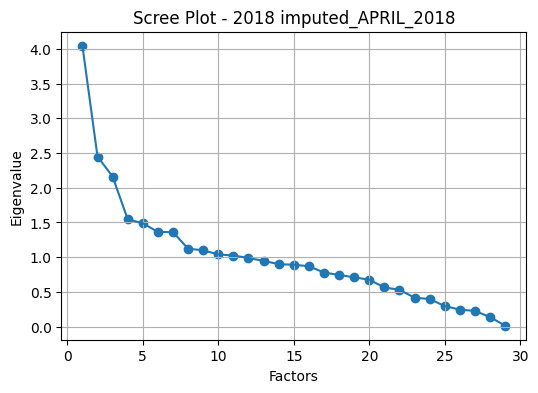

Dataset: imputed_JANUARY_2018.csv


C:\Users\SHANIA\AppData\Local\Temp\ipykernel_2780\2203899059.py:67: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_consistent = df_consistent.replace([np.inf, -np.inf], np.nan).dropna()


Shape after cleaning: (180262, 29)
KMO=0.595, Bartlett p=0.00000


c:\Users\SHANIA\AppData\Local\Programs\Python\Python314\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


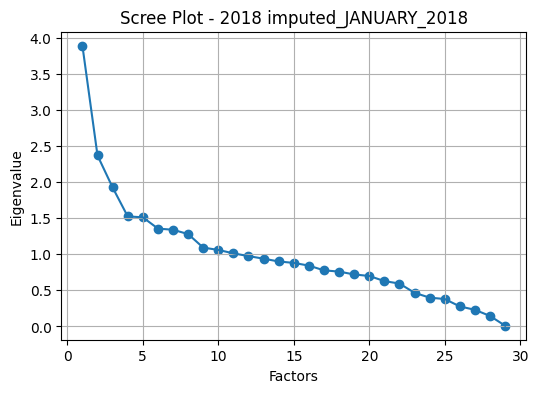

Dataset: imputed_JULY_2018.csv


C:\Users\SHANIA\AppData\Local\Temp\ipykernel_2780\2203899059.py:67: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_consistent = df_consistent.replace([np.inf, -np.inf], np.nan).dropna()


Shape after cleaning: (182956, 29)
KMO=0.650, Bartlett p=0.00000


c:\Users\SHANIA\AppData\Local\Programs\Python\Python314\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


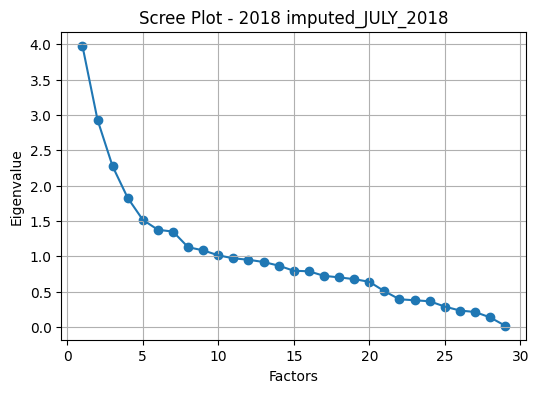

Dataset: imputed_OCTOBER_2018.csv


C:\Users\SHANIA\AppData\Local\Temp\ipykernel_2780\2203899059.py:67: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_consistent = df_consistent.replace([np.inf, -np.inf], np.nan).dropna()


Shape after cleaning: (179204, 29)
KMO=0.594, Bartlett p=0.00000


c:\Users\SHANIA\AppData\Local\Programs\Python\Python314\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


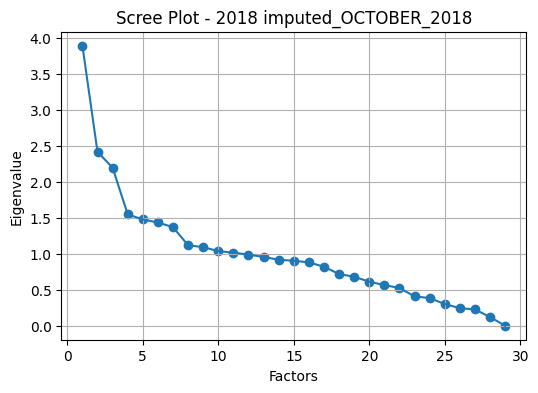


=== Processing Year: 2019 ===
Dataset: imputed_APRIL_2019.csv


C:\Users\SHANIA\AppData\Local\Temp\ipykernel_2780\2203899059.py:67: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_consistent = df_consistent.replace([np.inf, -np.inf], np.nan).dropna()


Shape after cleaning: (172284, 29)
KMO=0.603, Bartlett p=0.00000


c:\Users\SHANIA\AppData\Local\Programs\Python\Python314\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


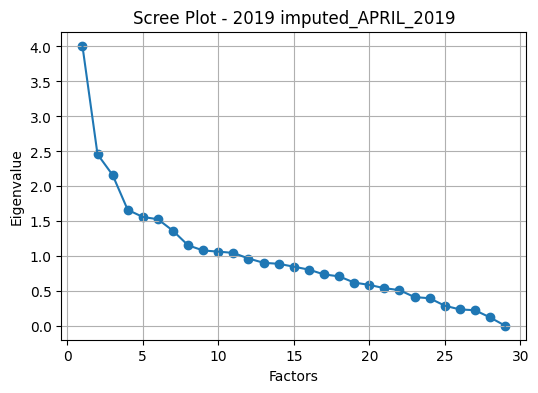

Dataset: imputed_JANUARY_2019.csv


C:\Users\SHANIA\AppData\Local\Temp\ipykernel_2780\2203899059.py:67: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_consistent = df_consistent.replace([np.inf, -np.inf], np.nan).dropna()


Shape after cleaning: (181233, 29)
KMO=0.646, Bartlett p=0.00000


c:\Users\SHANIA\AppData\Local\Programs\Python\Python314\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


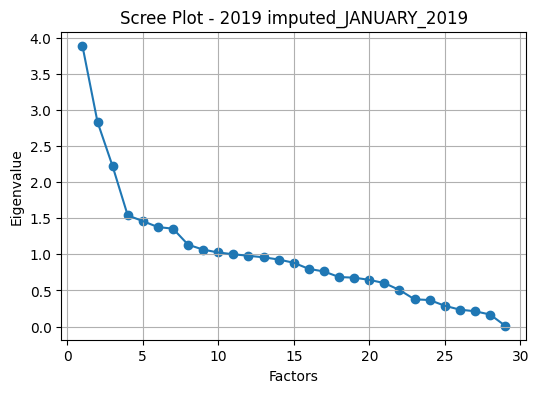

Dataset: imputed_JULY_2019.csv


C:\Users\SHANIA\AppData\Local\Temp\ipykernel_2780\2203899059.py:67: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_consistent = df_consistent.replace([np.inf, -np.inf], np.nan).dropna()


Shape after cleaning: (175438, 29)
KMO=0.601, Bartlett p=0.00000


c:\Users\SHANIA\AppData\Local\Programs\Python\Python314\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


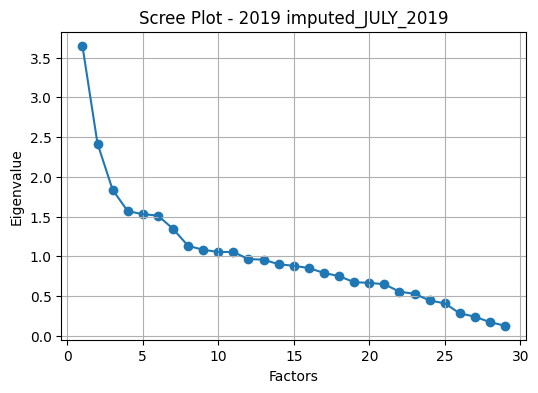

Dataset: imputed_OCTOBER_2019.csv


C:\Users\SHANIA\AppData\Local\Temp\ipykernel_2780\2203899059.py:67: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_consistent = df_consistent.replace([np.inf, -np.inf], np.nan).dropna()


Shape after cleaning: (178067, 29)
KMO=0.595, Bartlett p=0.00000


c:\Users\SHANIA\AppData\Local\Programs\Python\Python314\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


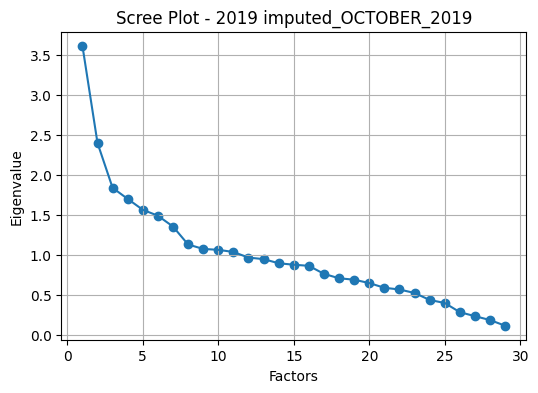


=== Processing Year: 2022 ===
Dataset: imputed_AUGUST_2022.csv


C:\Users\SHANIA\AppData\Local\Temp\ipykernel_2780\2203899059.py:67: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_consistent = df_consistent.replace([np.inf, -np.inf], np.nan).dropna()
c:\Users\SHANIA\AppData\Local\Programs\Python\Python314\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Shape after cleaning: (45054, 29)
KMO=0.572, Bartlett p=0.00000


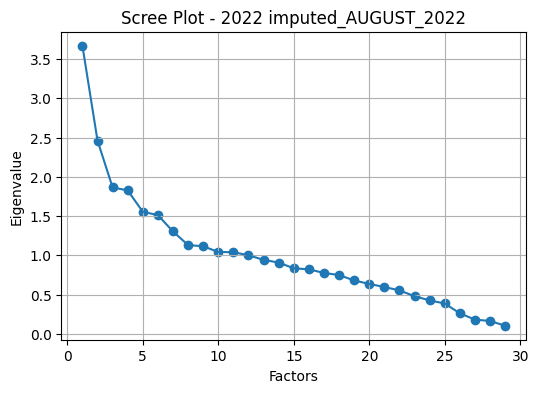

Dataset: imputed_DECEMBER_2022.csv


C:\Users\SHANIA\AppData\Local\Temp\ipykernel_2780\2203899059.py:67: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_consistent = df_consistent.replace([np.inf, -np.inf], np.nan).dropna()


Shape after cleaning: (45687, 29)
KMO=0.584, Bartlett p=0.00000


c:\Users\SHANIA\AppData\Local\Programs\Python\Python314\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


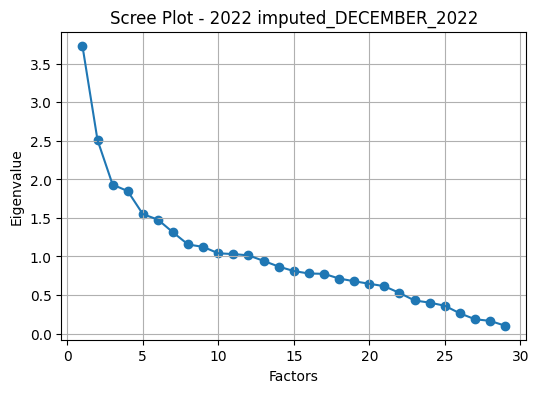

Dataset: imputed_JULY_2022.csv


C:\Users\SHANIA\AppData\Local\Temp\ipykernel_2780\2203899059.py:67: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_consistent = df_consistent.replace([np.inf, -np.inf], np.nan).dropna()


Shape after cleaning: (183856, 29)
KMO=0.611, Bartlett p=0.00000


c:\Users\SHANIA\AppData\Local\Programs\Python\Python314\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


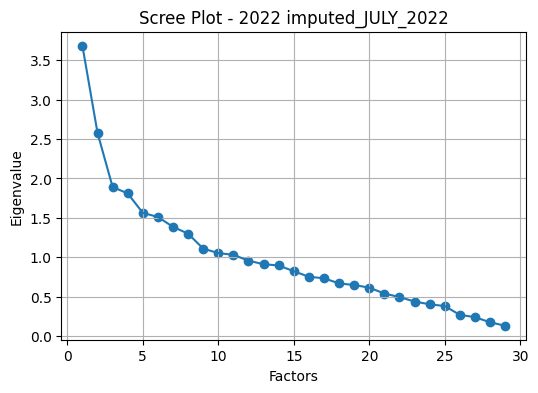

Dataset: imputed_NOVEMBER_2022.csv


C:\Users\SHANIA\AppData\Local\Temp\ipykernel_2780\2203899059.py:67: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_consistent = df_consistent.replace([np.inf, -np.inf], np.nan).dropna()


Shape after cleaning: (45561, 29)
KMO=0.617, Bartlett p=0.00000


c:\Users\SHANIA\AppData\Local\Programs\Python\Python314\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


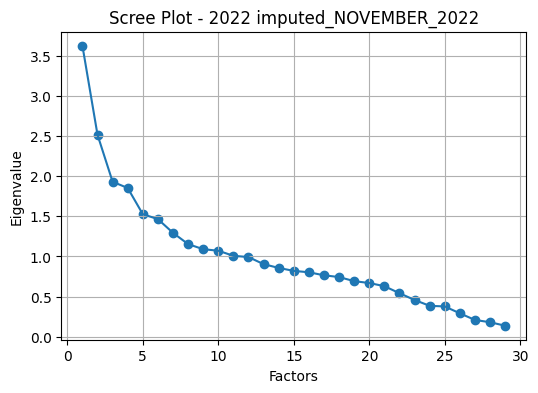

Dataset: imputed_OCTOBER_2022.csv


C:\Users\SHANIA\AppData\Local\Temp\ipykernel_2780\2203899059.py:67: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_consistent = df_consistent.replace([np.inf, -np.inf], np.nan).dropna()


Shape after cleaning: (183602, 29)
KMO=0.614, Bartlett p=0.00000


c:\Users\SHANIA\AppData\Local\Programs\Python\Python314\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


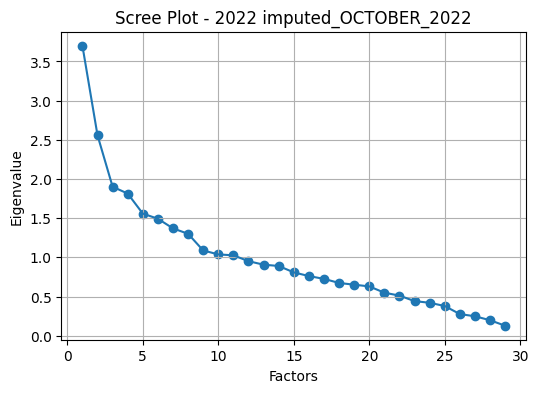

Dataset: imputed_SEPTEMBER_2022.csv


C:\Users\SHANIA\AppData\Local\Temp\ipykernel_2780\2203899059.py:67: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_consistent = df_consistent.replace([np.inf, -np.inf], np.nan).dropna()


Shape after cleaning: (46261, 29)
KMO=0.557, Bartlett p=0.00000


c:\Users\SHANIA\AppData\Local\Programs\Python\Python314\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


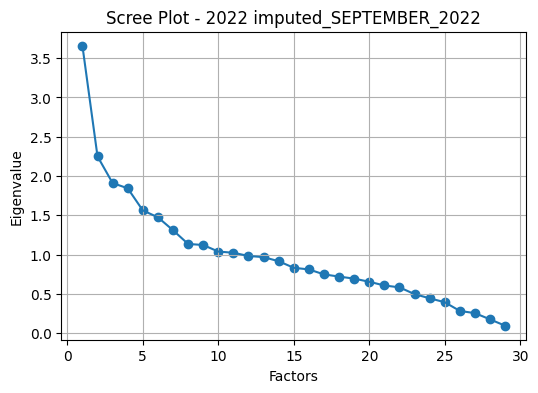


=== Processing Year: 2023 ===
Dataset: imputed_APRIL_2023.csv


C:\Users\SHANIA\AppData\Local\Temp\ipykernel_2780\2203899059.py:67: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_consistent = df_consistent.replace([np.inf, -np.inf], np.nan).dropna()


Shape after cleaning: (181424, 29)
KMO=0.544, Bartlett p=0.00000


c:\Users\SHANIA\AppData\Local\Programs\Python\Python314\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


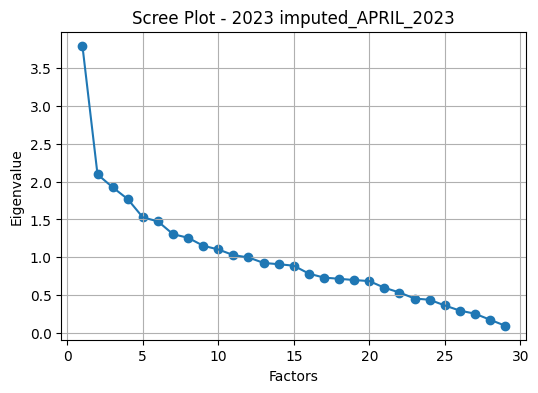

Dataset: imputed_AUGUST_2023.csv


C:\Users\SHANIA\AppData\Local\Temp\ipykernel_2780\2203899059.py:67: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_consistent = df_consistent.replace([np.inf, -np.inf], np.nan).dropna()


Shape after cleaning: (44999, 29)
KMO=0.643, Bartlett p=0.00000


c:\Users\SHANIA\AppData\Local\Programs\Python\Python314\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


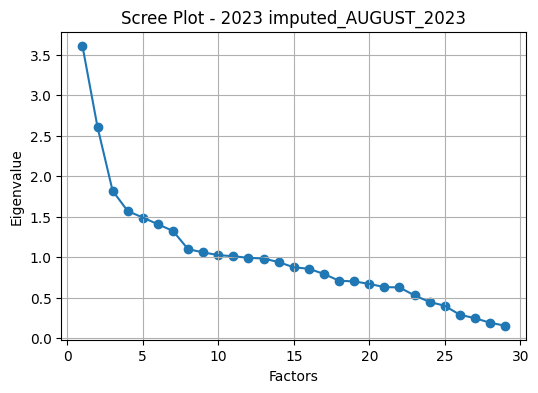

Dataset: imputed_DECEMBER_2023.csv


C:\Users\SHANIA\AppData\Local\Temp\ipykernel_2780\2203899059.py:67: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_consistent = df_consistent.replace([np.inf, -np.inf], np.nan).dropna()


Shape after cleaning: (44141, 29)
KMO=0.654, Bartlett p=0.00000


c:\Users\SHANIA\AppData\Local\Programs\Python\Python314\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


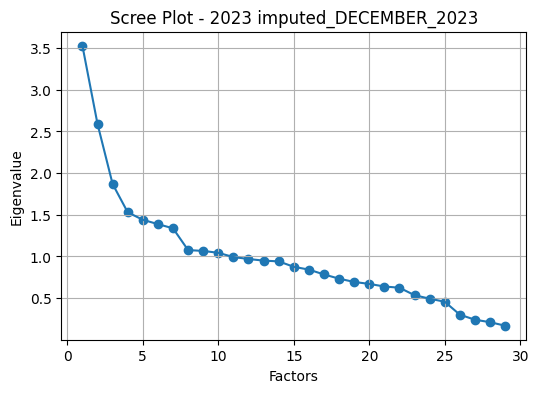

Dataset: imputed_FEBRUARY_2023.csv


C:\Users\SHANIA\AppData\Local\Temp\ipykernel_2780\2203899059.py:67: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_consistent = df_consistent.replace([np.inf, -np.inf], np.nan).dropna()


Shape after cleaning: (47044, 29)
KMO=0.587, Bartlett p=0.00000


c:\Users\SHANIA\AppData\Local\Programs\Python\Python314\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


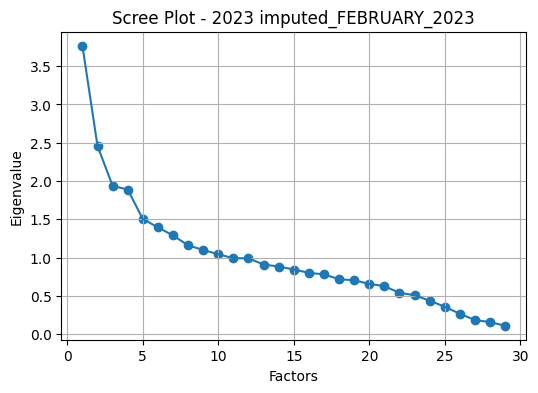

Dataset: imputed_JANUARY_2023.csv


C:\Users\SHANIA\AppData\Local\Temp\ipykernel_2780\2203899059.py:67: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_consistent = df_consistent.replace([np.inf, -np.inf], np.nan).dropna()


Shape after cleaning: (184113, 29)
KMO=0.543, Bartlett p=0.00000


c:\Users\SHANIA\AppData\Local\Programs\Python\Python314\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


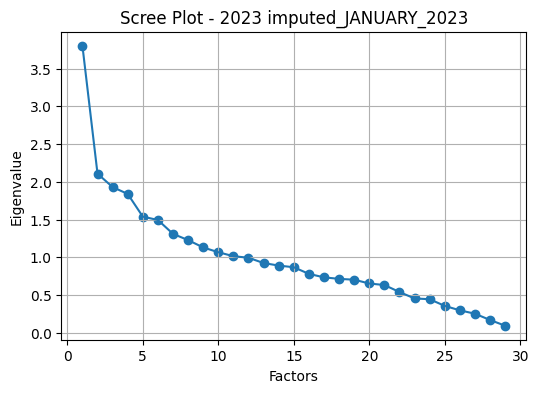

Dataset: imputed_JULY_2023.csv


C:\Users\SHANIA\AppData\Local\Temp\ipykernel_2780\2203899059.py:67: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_consistent = df_consistent.replace([np.inf, -np.inf], np.nan).dropna()


Shape after cleaning: (718567, 29)
KMO=0.635, Bartlett p=0.00000


c:\Users\SHANIA\AppData\Local\Programs\Python\Python314\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


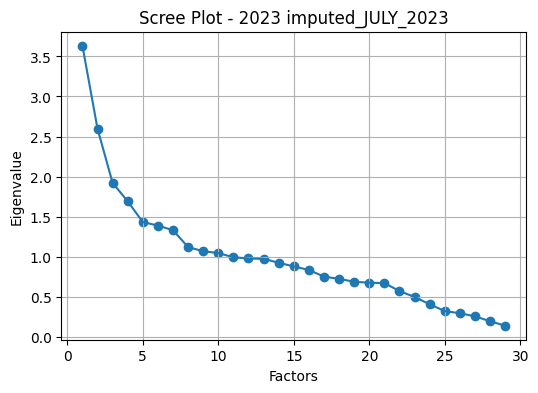

Dataset: imputed_JUNE_2023.csv


C:\Users\SHANIA\AppData\Local\Temp\ipykernel_2780\2203899059.py:67: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_consistent = df_consistent.replace([np.inf, -np.inf], np.nan).dropna()


Shape after cleaning: (46060, 29)
KMO=0.578, Bartlett p=0.00000


c:\Users\SHANIA\AppData\Local\Programs\Python\Python314\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


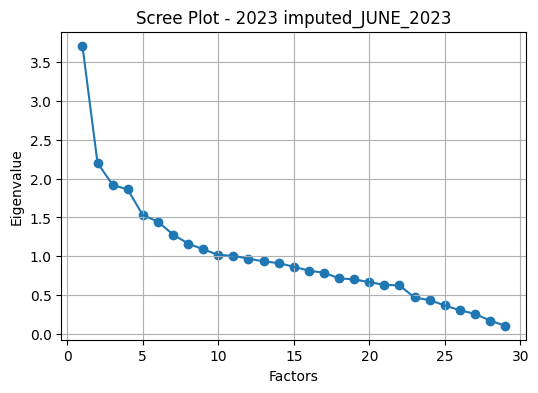

Dataset: imputed_MARCH_2023.csv


C:\Users\SHANIA\AppData\Local\Temp\ipykernel_2780\2203899059.py:67: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_consistent = df_consistent.replace([np.inf, -np.inf], np.nan).dropna()


Shape after cleaning: (46212, 29)
KMO=0.570, Bartlett p=0.00000


c:\Users\SHANIA\AppData\Local\Programs\Python\Python314\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


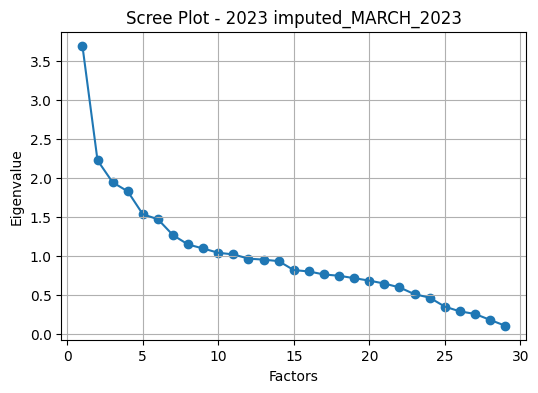

Dataset: imputed_MAY_2023.csv


C:\Users\SHANIA\AppData\Local\Temp\ipykernel_2780\2203899059.py:67: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_consistent = df_consistent.replace([np.inf, -np.inf], np.nan).dropna()


Shape after cleaning: (45505, 29)
KMO=0.566, Bartlett p=0.00000


c:\Users\SHANIA\AppData\Local\Programs\Python\Python314\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


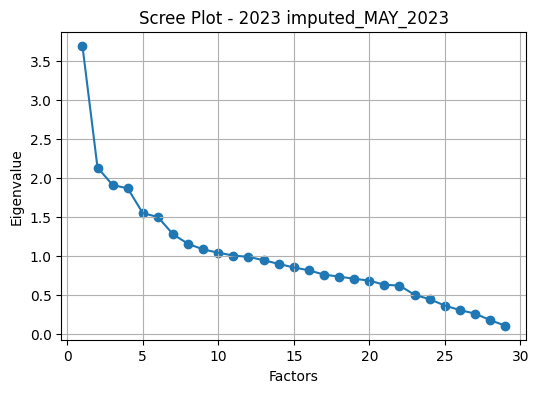

Dataset: imputed_NOVEMBER_2023.csv


C:\Users\SHANIA\AppData\Local\Temp\ipykernel_2780\2203899059.py:67: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_consistent = df_consistent.replace([np.inf, -np.inf], np.nan).dropna()
c:\Users\SHANIA\AppData\Local\Programs\Python\Python314\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Shape after cleaning: (44609, 29)
KMO=0.634, Bartlett p=0.00000


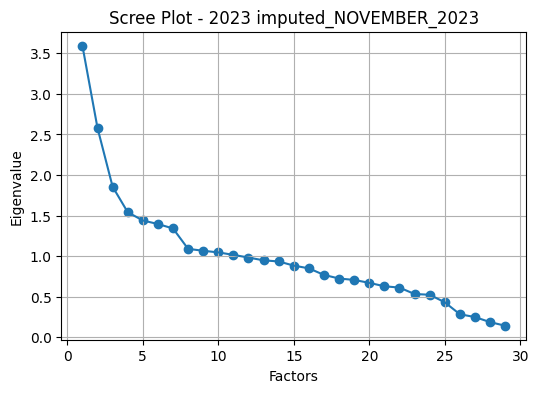

Dataset: imputed_OCTOBER_2023.csv


C:\Users\SHANIA\AppData\Local\Temp\ipykernel_2780\2203899059.py:67: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_consistent = df_consistent.replace([np.inf, -np.inf], np.nan).dropna()


Shape after cleaning: (179173, 29)
KMO=0.607, Bartlett p=0.00000


c:\Users\SHANIA\AppData\Local\Programs\Python\Python314\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


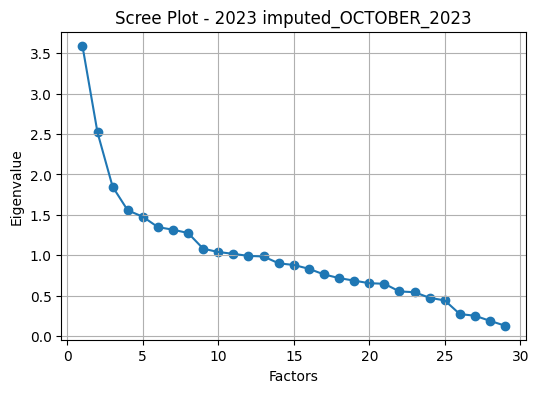

Dataset: imputed_SEPTEMBER_2023.csv


C:\Users\SHANIA\AppData\Local\Temp\ipykernel_2780\2203899059.py:67: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_consistent = df_consistent.replace([np.inf, -np.inf], np.nan).dropna()
c:\Users\SHANIA\AppData\Local\Programs\Python\Python314\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Shape after cleaning: (44659, 29)
KMO=0.641, Bartlett p=0.00000


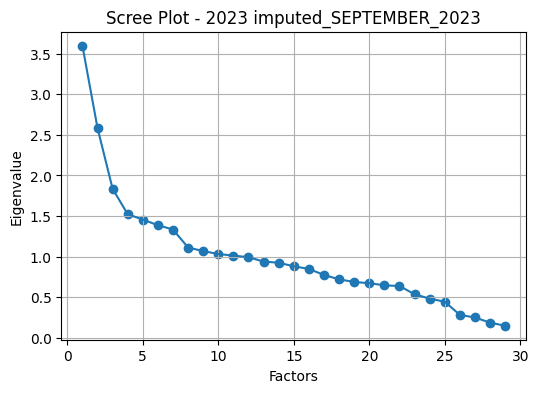


=== Processing Year: 2024 ===
Dataset: imputed_APRIL_2024.csv


C:\Users\SHANIA\AppData\Local\Temp\ipykernel_2780\2203899059.py:67: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_consistent = df_consistent.replace([np.inf, -np.inf], np.nan).dropna()


Shape after cleaning: (175511, 29)
KMO=0.613, Bartlett p=0.00000


c:\Users\SHANIA\AppData\Local\Programs\Python\Python314\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


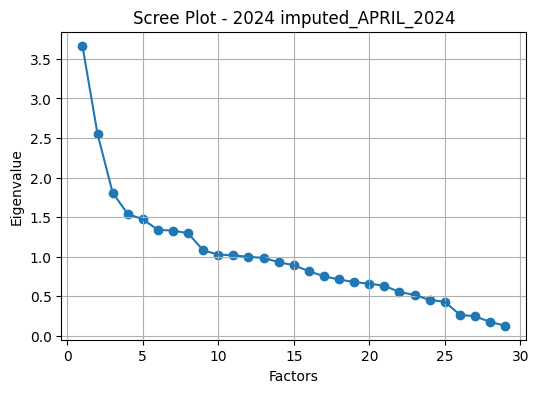

Dataset: imputed_AUGUST_2024.csv


C:\Users\SHANIA\AppData\Local\Temp\ipykernel_2780\2203899059.py:67: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_consistent = df_consistent.replace([np.inf, -np.inf], np.nan).dropna()
c:\Users\SHANIA\AppData\Local\Programs\Python\Python314\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Shape after cleaning: (43375, 29)
KMO=0.650, Bartlett p=0.00000


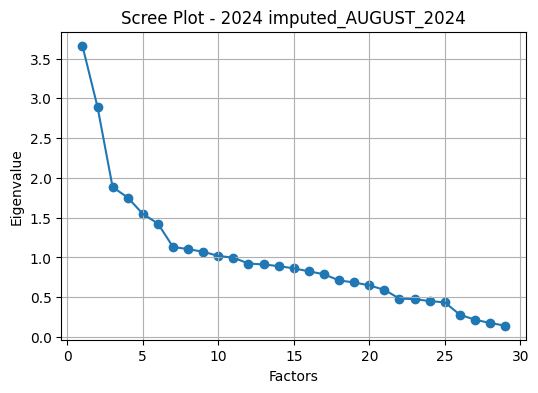

Dataset: imputed_FEBRUARY_2024.csv


C:\Users\SHANIA\AppData\Local\Temp\ipykernel_2780\2203899059.py:67: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_consistent = df_consistent.replace([np.inf, -np.inf], np.nan).dropna()
c:\Users\SHANIA\AppData\Local\Programs\Python\Python314\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Shape after cleaning: (44598, 29)
KMO=0.658, Bartlett p=0.00000


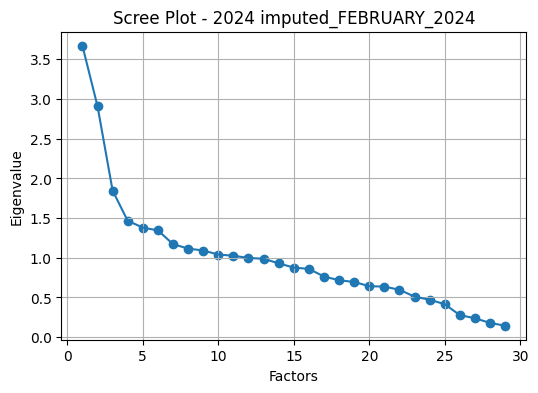

Dataset: imputed_JANUARY_2024.csv


C:\Users\SHANIA\AppData\Local\Temp\ipykernel_2780\2203899059.py:67: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_consistent = df_consistent.replace([np.inf, -np.inf], np.nan).dropna()


Shape after cleaning: (707981, 29)
KMO=0.603, Bartlett p=0.00000


c:\Users\SHANIA\AppData\Local\Programs\Python\Python314\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


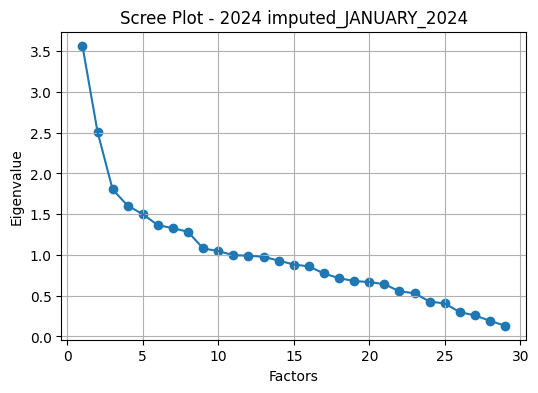

Dataset: imputed_JULY_2024.csv


C:\Users\SHANIA\AppData\Local\Temp\ipykernel_2780\2203899059.py:67: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_consistent = df_consistent.replace([np.inf, -np.inf], np.nan).dropna()


Shape after cleaning: (173259, 29)
KMO=0.629, Bartlett p=0.00000


c:\Users\SHANIA\AppData\Local\Programs\Python\Python314\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


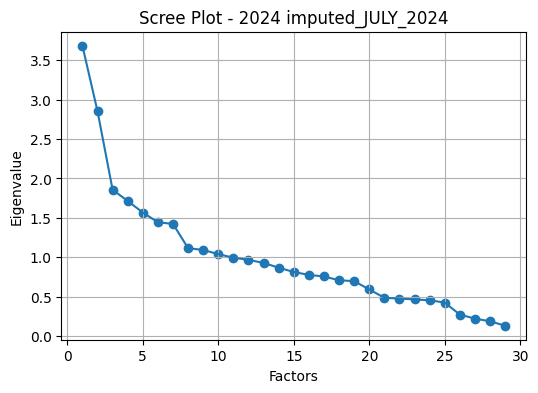

Dataset: imputed_JUNE_2024.csv


C:\Users\SHANIA\AppData\Local\Temp\ipykernel_2780\2203899059.py:67: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_consistent = df_consistent.replace([np.inf, -np.inf], np.nan).dropna()
c:\Users\SHANIA\AppData\Local\Programs\Python\Python314\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Shape after cleaning: (43074, 29)
KMO=0.643, Bartlett p=0.00000


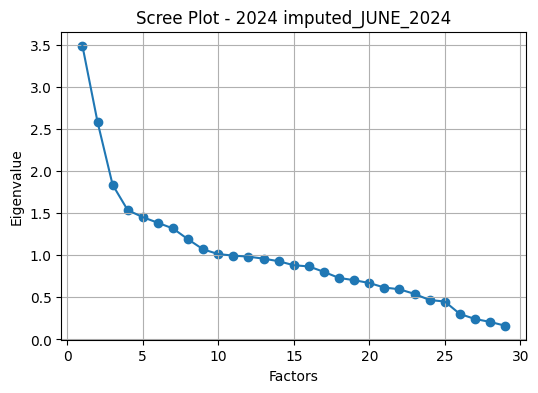

Dataset: imputed_MARCH_2024.csv


C:\Users\SHANIA\AppData\Local\Temp\ipykernel_2780\2203899059.py:67: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_consistent = df_consistent.replace([np.inf, -np.inf], np.nan).dropna()


Shape after cleaning: (44063, 29)
KMO=0.632, Bartlett p=0.00000


c:\Users\SHANIA\AppData\Local\Programs\Python\Python314\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


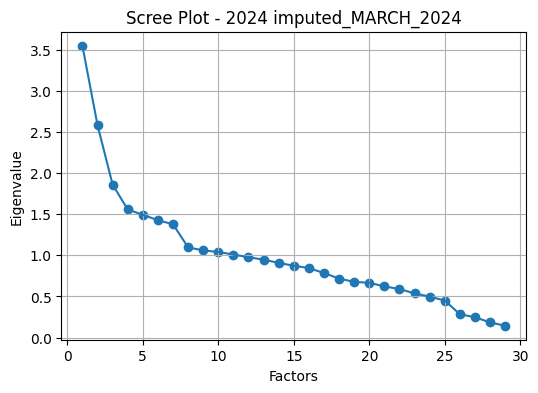

Dataset: imputed_MAY_2024.csv


C:\Users\SHANIA\AppData\Local\Temp\ipykernel_2780\2203899059.py:67: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_consistent = df_consistent.replace([np.inf, -np.inf], np.nan).dropna()


Shape after cleaning: (43717, 28)
KMO=0.634, Bartlett p=0.00000


c:\Users\SHANIA\AppData\Local\Programs\Python\Python314\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


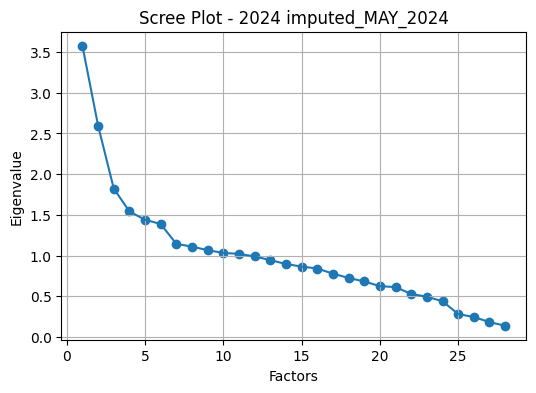

,Year,Dataset,KMO,Bartlett_p,Factors>1
0,2018,imputed_APRIL_2018,0.619774,0.0,11
1,2018,imputed_JANUARY_2018,0.594862,0.0,11
2,2018,imputed_JULY_2018,0.650211,0.0,10
3,2018,imputed_OCTOBER_2018,0.593733,0.0,11
4,2019,imputed_APRIL_2019,0.603085,0.0,11
5,2019,imputed_JANUARY_2019,0.646311,0.0,11
6,2019,imputed_JULY_2019,0.601465,0.0,11
7,2019,imputed_OCTOBER_2019,0.595189,0.0,11
8,2022,imputed_AUGUST_2022,0.571860,0.0,11
9,2022,imputed_DECEMBER_2022,0.583725,0.0,12


In [ ]:
import json
from pathlib import Path
import pandas as pd
import numpy as np
from factor_analyzer import FactorAnalyzer, calculate_kmo, calculate_bartlett_sphericity
import matplotlib.pyplot as plt


# ------------------------------------------------------------
# Step 4–8: Full Dataset Loop, FA, and Summary
# ------------------------------------------------------------
results = []

for year_folder in sorted(IMPUTED_ROOT.iterdir()):
    if not year_folder.is_dir():
        continue
    
    print(f"\n=== Processing Year: {year_folder.name} ===")
    
    for file in sorted(year_folder.glob("imputed_*.csv")):
        print(f"Dataset: {file.name}")
        df = pd.read_csv(file, low_memory=False)
        
        # Normalize columns
        df.columns = [normalize_name(c) for c in df.columns]
        
        # Match consistent variables
        matched_vars = [v for v in consistent_vars_norm if v in df.columns]
        df_consistent = df[matched_vars].copy()   # safe copy
        
        # Cleaning
        for col in df_consistent.columns:
            if not pd.api.types.is_numeric_dtype(df_consistent[col]):
                df_consistent.loc[:, col] = pd.Categorical(df_consistent[col]).codes
        
        df_consistent = df_consistent.replace([np.inf, -np.inf], np.nan).dropna()
        df_consistent = df_consistent.loc[:, df_consistent.nunique() > 1]
        
        print("Shape after cleaning:", df_consistent.shape)
        
        # Step 5: Suitability Tests
        try:
            kmo_all, kmo_model = calculate_kmo(df_consistent)
            chi_square_value, p_value = calculate_bartlett_sphericity(df_consistent)
            print(f"KMO={kmo_model:.3f}, Bartlett p={p_value:.5f}")
        except Exception as e:
            print("Suitability test failed:", e)
            continue
        
        # Step 6: Factor Extraction
        fa = FactorAnalyzer(rotation="varimax")
        fa.fit(df_consistent)
        
        ev, v = fa.get_eigenvalues()
        factors_gt1 = int(np.sum(np.array(ev) > 1))
        
        # Step 7: Inline Scree Plot (Notebook only)
        plt.figure(figsize=(6,4))
        plt.scatter(range(1, len(ev)+1), ev)
        plt.plot(range(1, len(ev)+1), ev)
        plt.title(f"Scree Plot - {year_folder.name} {file.stem}")
        plt.xlabel("Factors")
        plt.ylabel("Eigenvalue")
        plt.grid(True)
        plt.show()
        
        # Step 8: Save Loadings + Append Summary
        loadings = pd.DataFrame(fa.loadings_, index=df_consistent.columns)
        loadings.to_csv(OUTPUT_RESULTS / f"loadings_{year_folder.name}_{file.stem}.csv")
        
        results.append({
            "Year": year_folder.name,
            "Dataset": file.stem,
            "KMO": kmo_model,
            "Bartlett_p": p_value,
            "Factors>1": factors_gt1
        })

# Final summary table
summary = pd.DataFrame(results)
summary.to_csv(OUTPUT_RESULTS / "FA_summary.csv", index=False)
summary
